In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import seaborn
from os.path import join
%matplotlib inline

In [2]:
from PRmm.io import DmeDumpReader
from PRmm.model import Fixture

dmeDump_3016 = DmeDumpReader(
    "/home/UNIXHOME/dalexander/Projects/SequelFrenzy/All4Mers-3150005-0026-bakeoff/T2B-covariance-fix/m54004_151201_015904.dme-dump.h5"
    )
fx_3016 = Fixture.fromIniFile(
    "/home/UNIXHOME/dalexander/Projects/SequelFrenzy/All4Mers-3150005-0026-bakeoff/fixture.ini",
    "T2B.3016"
    )
fx_PoC = Fixture.fromIniFile(
    "/home/UNIXHOME/dalexander/Projects/SequelFrenzy/All4Mers-3150005-0026-bakeoff/fixture.ini",
    "PoC"
    )

# ZMWs with no alignment under T2B, but have one under PoC
badHns = [
    11142012,
    11272353,
    11273086,
    11731834,
    11797121 ]
goodHns = [
    10944915,
    10945158,
    10945181,
    11010219,
    11010702 ]

In [3]:
for hn in zmwsOfInterest:
    print fx_PoC[hn].baseRegions.hqRegion

<Region:         HQ       0     987>
<Region:         HQ       0    1086>
<Region:         HQ       0     921>
<Region:         HQ       0   10006>
<Region:         HQ       0    1246>
<Region:         HQ       0    1043>
<Region:         HQ       0    1410>
<Region:         HQ       0     434>
<Region:         HQ       0    2496>
<Region:         HQ       0    3250>


In [4]:
dmeZmw1 = dmeDump_3016.hole(11142012)
zmwFx1 = fx_3016[11142012]
pocZmwFx1 = fx_PoC[11142012]

In [5]:
blocksWithEmUpdates = np.flatnonzero(dmeZmw1.iterations != 0)

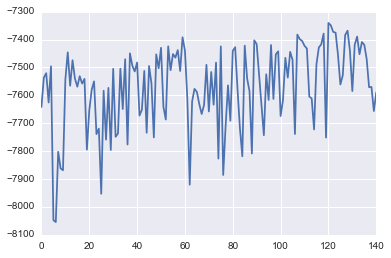

In [6]:
plt.plot(dmeZmw1.loglikelihood[blocksWithEmUpdates])

In [7]:
dmeZmw1.smoothedMean.shape

(567, 5, 2)

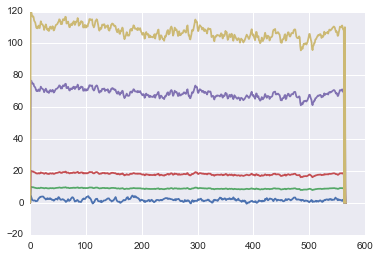

In [8]:
plt.plot(dmeZmw1.smoothedMean[:,:,0])

In [9]:
from PRmm.model import Region
from PRmm.extras.ellipse import *

from intervaltree import IntervalTree, Interval
import math

def baselineSubtract(rawTrace, baseline, blockSize, baselineIsBackwards=False):
    """
    Calculate the baseline subtracted trace
    
    baselineIsBackwards=True is needed for old versions where the G,R channel order
    was reversed in the DME dump baseline output
    """
    if baselineIsBackwards:
        realBaseline = np.empty_like(baseline)
        realBaseline[:,0] = baseline[:,1]
        realBaseline[:,1] = baseline[:,0]
        baseline = realBaseline
    assert len(baseline) == len(blockSize)
    assert sum(blockSize)== rawTrace.shape[1]
    expandedBaseline = np.repeat(np.transpose(baseline), blockSize, axis=1)
    assert expandedBaseline.shape == rawTrace.shape
    return rawTrace - expandedBaseline


def plot2C2AScatterTimeSeriesWithDme(fxZmw, dmeZmw):
    """
    Plot a 2C2A scatter plot for every `frameInterval` frames; overlay
    information about HQRegion and alignment(s), if found in the dataset.    
    """        
    t = baselineSubtract(fxZmw.cameraTrace, dmeZmw.baseline, dmeZmw.blockSize, True)        
    df = pd.DataFrame(np.transpose(t), columns=["C1", "C2"])

    # what is the extent of the data?  force a square perspective so
    # we don't distort the spectral angle
    xmin = ymin = min(df.min())
    xmax = ymax = max(df.max())

    def fracX(frac): return xmin + (xmax - xmin) * frac
    def fracY(frac): return ymin + (ymax - ymin) * frac

    #numPanes = int(math.ceil(float(zmwFixture.numFrames) / frameInterval))
    
    numPanes = np.sum(dmeZmw.blockSize > 0)
    numCols = 6
    numRows = int(math.ceil(float(numPanes) / numCols))
    paneSize = np.array([3, 3])

    figsize = np.array([numCols, numRows]) * paneSize
    fig, ax = plt.subplots(numRows, numCols, sharex=True, sharey=True,
                           figsize=figsize, dpi=200)
    axr = ax.ravel()

    details = "" # TODO
    fig.suptitle("%s\n%s" % (fxZmw.zmwName, details), fontsize=20)


    alnIntervals = IntervalTree()
    for r in fxZmw.traceRegions:
        if r.regionType == Region.ALIGNMENT_REGION:
            alnIntervals.addi(r.startFrame, r.endFrame)

    def overlapsAln(frameStart, frameEnd):
        if alnIntervals.search(frameStart, frameEnd):
            return True
        else:
            return False
        
    nonemptyBlocks = np.flatnonzero(dmeZmw.blockSize > 0)
        
    for i in xrange(numPanes):
        j = nonemptyBlocks[i]
        frameSpan = startFrame, endFrame = dmeZmw.startFrame[j], dmeZmw.endFrame[j]
        axr[i].set_xlim(xmin, xmax)
        axr[i].set_ylim(ymin, ymax)
        axr[i].plot(df.C1[startFrame:endFrame], df.C2[startFrame:endFrame], ".", alpha=0.1)

        baseSpan = fxZmw.baseIntervalFromFrames(*frameSpan)
        axr[i].text(fracX(0.6), fracY(0.9), "/%d_%d" %  baseSpan)

        if overlapsAln(*frameSpan):
            axr[i].hlines(fracY(1.0), xmin, xmax, colors=["red"], linewidth=4)

            
        # Overlay ellipsoids    
        es = [ covarianceEllipse3(m, c3, 3.0)
               for (m, c3) in zip(dmeZmw.smoothedMean[j],
                                  dmeZmw.smoothedCovariance[j]) ]
        for e in es:
            axr[i].add_artist(e)

    plt.subplots_adjust(top=0.97)
    return axr
    

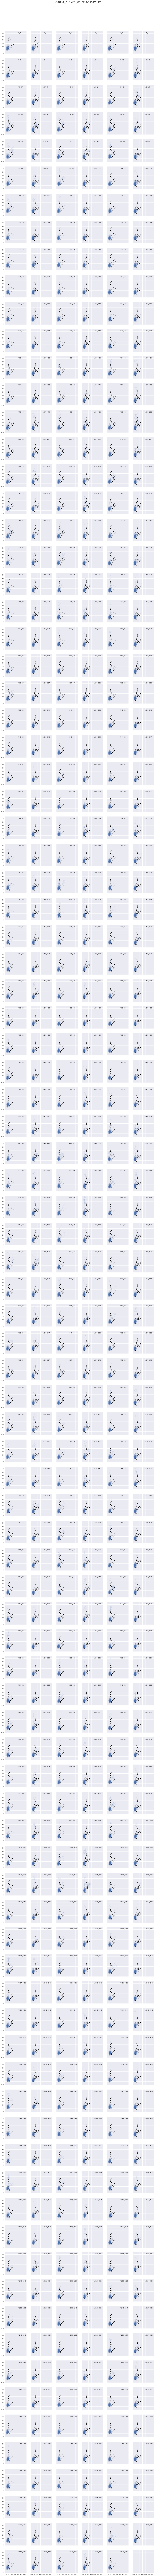

In [10]:
plot2C2AScatterTimeSeriesWithDme(zmwFx1, dmeZmw1);

In [11]:
pocZmwFx1.traceRegions.alignment

<Region:  ALIGNMENT   12615  533585>

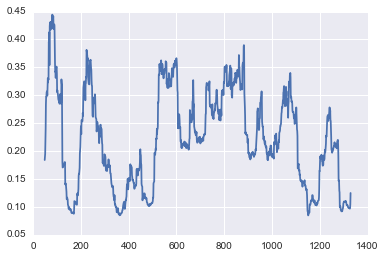

In [28]:
# Whats' the pulse rate here???
for (col, hns) in enumerate([goodHns, badHns]):
    for (i, hn) in enumerate(hns):

    interarrivalTimes = np.ediff1d(zmwFx1.pulseStartFrame) / zmwFx1.frameRate
    ca = ax[i, col]

    plt.plot(1. / pd.rolling_mean(interarrivalTimes, 50))

In [14]:
reload(ap)

<module 'PRmm.extras.activityPlots' from '/Users/dalexander/Dropbox/Sources/git/PRmm/PRmm/extras/activityPlots.pyc'>

In [ ]:
zmwFx1._bases.offsetBegin